In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 58.9 MB/s 
     |████████████████████████████████| 182 kB 99.4 MB/s 


In [2]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 799 kB 4.5 MB/s 
     |████████████████████████████████| 512 kB 95.8 MB/s 
     |████████████████████████████████| 125 kB 87.9 MB/s 


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
import pandas as pd
import numpy as np

import tqdm as tqsm
import re
import os

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from transformers import BertTokenizer as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
# from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

In [5]:
from google.colab import drive
drive.mount('/content/bert', force_remount=True)

Mounted at /content/bert


**Creating one base class**

In [8]:
class CFG:
    seed = 42
    train_path = '/content/bert/MyDrive/bert/train1.csv'
    test_path = '/content/bert/MyDrive/bert/test.csv'
    sample_submit_path = '/content/bert/MyDrive/bert/sample_submission.csv'
  
    # model_name = '/kaggle/input/transformers/bert-base-uncased'
    model_name = 'bert-base-uncased'
    class_labels =['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    batch_size = 4
    max_len = 512

pl.seed_everything(CFG.seed)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

**Importing the database: download the data from** :https://www.kaggle.com/competitions/feedback-prize-english-language-learning/data

In [9]:
data_frame = pd.read_csv(CFG.train_path)
test_dataframe = pd.read_csv(CFG.test_path)
LEN_DF = len(data_frame)

**Taking a look in the data**:

In [13]:
data_frame.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [14]:
test_dataframe

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [15]:
data_frame.full_text[0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [16]:
test_dataframe.full_text[0]

"when a person has no experience on a job their is always going to be good people to help you and try to explane the job you need to get done in life you were not born with knowing everything. Life is bassicly about learing new things every single day even though without experience because life is simple and we must live happy and around with the people we love. When a person thinks they know everything in life they dont do good because they trying to make the other person less then others you must be kind to those the dont have experience because you may not know some day you will go to a different country. When you dont know anyting because you not from their so you going to need help from others to explain you about the culture or how to eat a food because you have to no experience on the new country. You must help a person the has no experience because maybe you may need help from the person the you didnt want to help.\n\nyes, even thought you may not have experience in the type of

**Simple data cleaning**:

In [17]:
data_frame['full_text'] = data_frame["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

test_dataframe['full_text'] = test_dataframe["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

In [18]:
data_frame['full_text'] = data_frame["full_text"].replace(re.compile(r"[\']"), " ", regex=True)
test_dataframe['full_text'] = test_dataframe["full_text"].replace(re.compile(r"[\']"), " ", regex=True)

In [ ]:
# train_df, val_df = train_test_split(df, test_size=0.05)

In [19]:
data_frame[CFG.class_labels].describe().T

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.0,3.127077,0.662542,1.0,2.5,3.0,3.5,5.0
syntax,3911.0,3.028254,0.644399,1.0,2.5,3.0,3.5,5.0
vocabulary,3911.0,3.235745,0.583148,1.0,3.0,3.0,3.5,5.0
phraseology,3911.0,3.116850,0.655997,1.0,2.5,3.0,3.5,5.0
grammar,3911.0,3.032856,0.699841,1.0,2.5,3.0,3.5,5.0
conventions,3911.0,3.081053,0.671450,1.0,2.5,3.0,3.5,5.0


In [22]:
BERT_MODEL_NAME = CFG.model_name
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
# tokenizer =  AutoTokenizer.from_pretrained(
#                 CFG.model_name
# )

 # The original Kaggle notebook is running offline, the bert model can be importent from : https://www.kaggle.com/datasets/kozodoi/transformers 


**Creating dataset with Pytorch-lightning**

In [23]:

class FeedbackDataset(Dataset):
    def __init__(self, data, test_data,mode = "train"):
        self.mode = mode
        self.data = data
        self.test_data= test_data

        if self.mode == "train":
            # df = data_frame
            df = self.data
            self.inputs = df["full_text"]
            self.target = np.array(df.drop(["text_id", "full_text"], axis = 1))
            
            self.tokenizer = AutoTokenizer.from_pretrained(
                'bert-base-uncased'
            )

        else:
            # df = test_dataframe
            df = self.test_data
            self.inputs = df["full_text"]
            self.ids = df["text_id"]
            self.tokenizer = AutoTokenizer.from_pretrained(
                'bert-base-uncased'
            )
           
            
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        text = self.inputs[idx]
        text_tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            truncation = True,
            padding = "max_length",
            max_length = CFG.max_len,
            return_tensors = 'pt',
        )
        otp = {
            "input_ids" : text_tokens["input_ids"].flatten(),
            "attention_mask" : text_tokens["attention_mask"].flatten()
        }
        if self.mode == "train":
            value = self.target[idx]
            return otp, torch.tensor(value, dtype = torch.float32)
        else:
            return otp

In [24]:
class FeedbackDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        
    def setup(self, stage = None):
        self.dataset = FeedbackDataset(data_frame, test_dataframe, mode = "train")
        self.test_dataset = FeedbackDataset(data_frame, test_dataframe, mode = "test")
        self.train_data, self.val_data = train_test_split( self.dataset, test_size=0.05)
        
    
    def train_dataloader(self):
        return DataLoader(self.train_data, 
                          batch_size = CFG.batch_size, 
                          shuffle = True,
                          # num_workers = os.cpu_count())
                          num_workers = 4,
                          # persistent_workers=False)
                           persistent_workers=True)
    def val_dataloader(self):
        return DataLoader(self.val_data, 
                          batch_size = CFG.batch_size, 
                          shuffle = False,
                          # num_workers = os.cpu_count())
                          num_workers = 4,
                          # persistent_workers=False)
                           persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, 
                          batch_size = self.batch_size, 
                          shuffle = False)

In [25]:
class FeedbackModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_model = AutoModel.from_pretrained('bert-base-uncased')
        self.regressor = nn.Sequential(
            nn.Linear(in_features = self.embedding_model.config.hidden_size, out_features = 6)
        )
    def forward(self, x):
        x = self.embedding_model(input_ids = x["input_ids"], 
                                 attention_mask = x['attention_mask']).last_hidden_state
        x = self.regressor(x)
        # print(self.embedding_model.config.hidden_size)
        return x

In [26]:
class FeedbackTrainingModule(pl.LightningModule):
    def __init__(self, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.model = FeedbackModel()
        self.loss_fn = nn.MSELoss()
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps

    

    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model.forward(X)[:, 0, :]
        loss = self.loss_fn(y, y_hat)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model.forward(X)[:, 0, :]
        loss = self.loss_fn(y, y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        X = batch
        temp = self.model.forward(X)
        y_hat = temp[:, 0, :]
        return y_hat

    # def configure_optimizers(self):
    #     return torch.optim.Adam(
    #         self.model.parameters(),
    #         lr = 0.001
    #     )

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5,no_deprecation_warning=True
        )
        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        return dict(
          optimizer=optimizer,
          lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
          )
        )


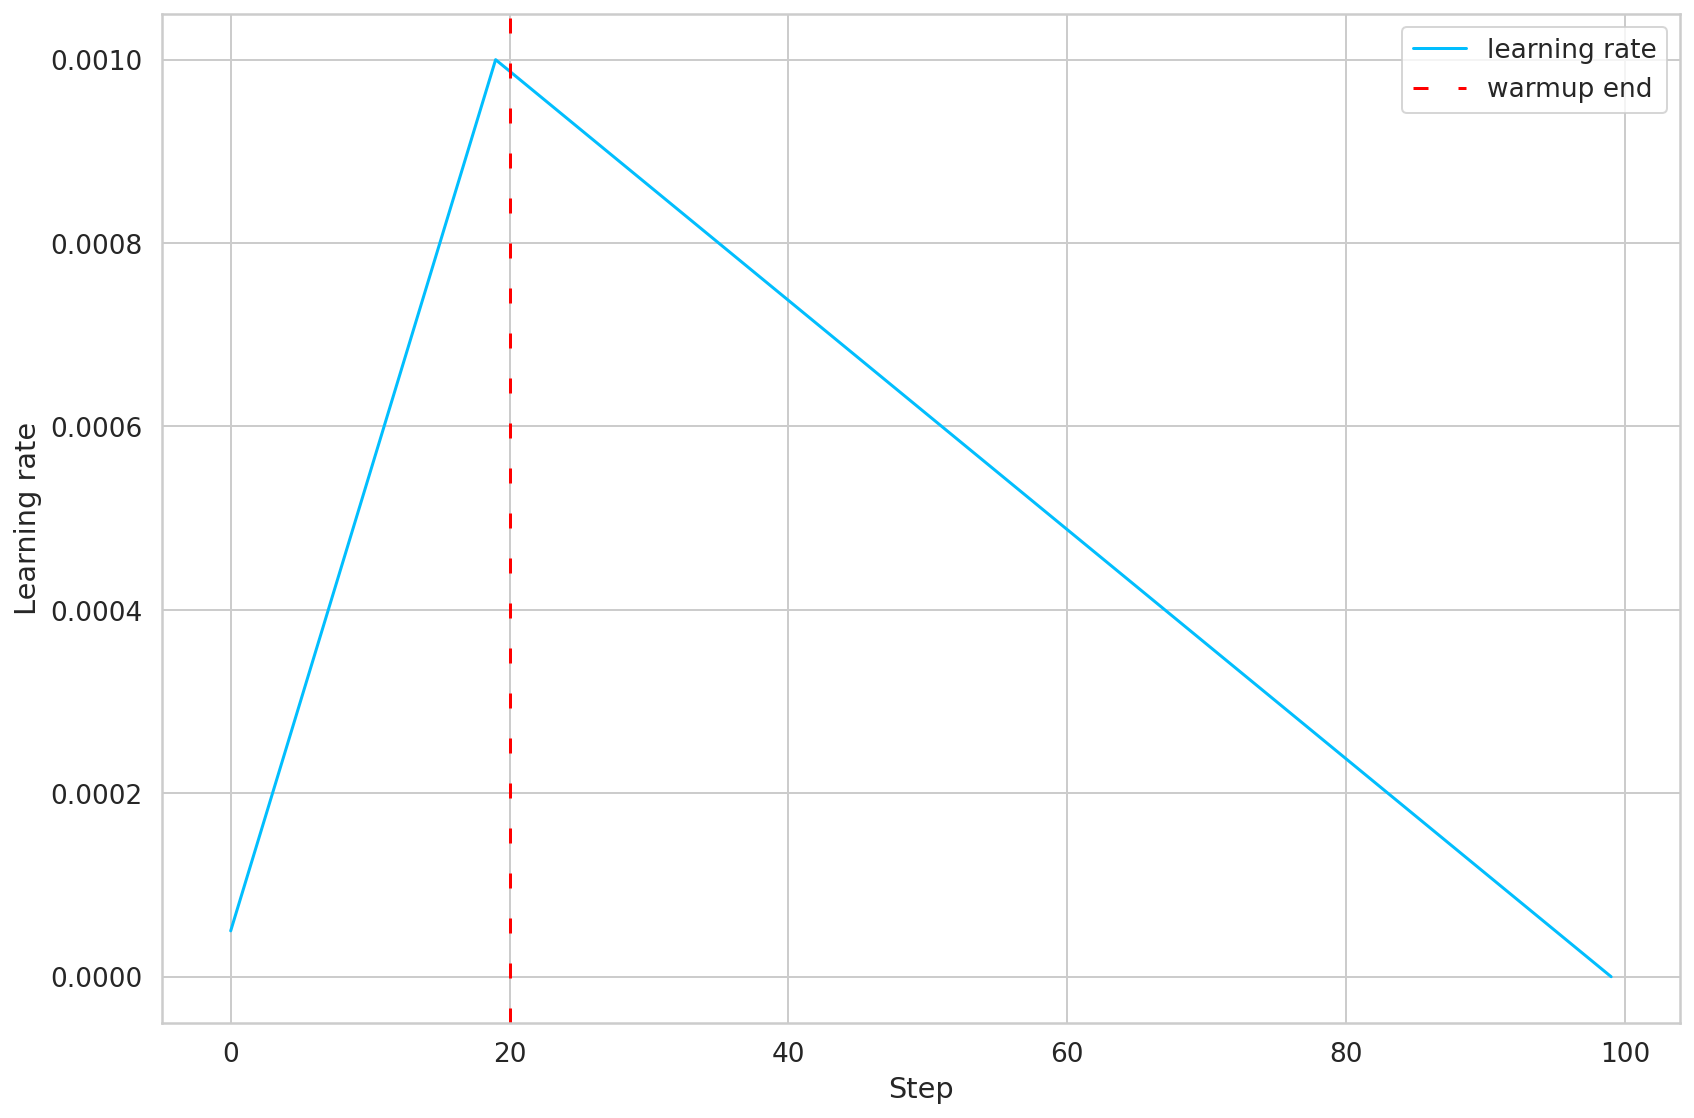

In [27]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001,no_deprecation_warning=True)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [28]:
N_EPOCHS = 10
# steps_per_epoch=300
# total_training_steps = steps_per_epoch * N_EPOCHS

steps_per_epoch=LEN_DF // CFG.batch_size
total_training_steps = steps_per_epoch * N_EPOCHS

In [29]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1954, 9770)

In [30]:
# model = FeedbackTrainingModule()
# data = FeedbackDataModule()
# trainer = pl.Trainer(
#     # default_root_dir = "/kaggle/working/",
#     accelerator = 'gpu' ,
#     max_epochs = 10,
   
model = FeedbackTrainingModule(
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)
data = FeedbackDataModule()
trainer = pl.Trainer(
    
    # default_root_dir = "/kaggle/working/",
    accelerator = 'gpu' ,
    # max_epochs = N_EPOCHS, 
    max_epochs = 5, 
   
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

In [31]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | model   | FeedbackModel | 109 M 
1 | loss_fn | MSELoss       | 0     
------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.947   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [32]:
test_dataloader = DataLoader(FeedbackDataset(data=data_frame, test_data=test_dataframe, mode="test"), batch_size = 4, shuffle = False)

In [33]:
torch.set_grad_enabled(False)
model.eval()
all_p = []
for batch_idx, batch in enumerate(test_dataloader):
    all_p.append(model.predict_step(batch, batch_idx))

In [34]:
def round_of_rating(number):
    return round(number * 2) / 2
# float_formatter = "{:.1f}".format

In [35]:
submission = pd.read_csv(CFG.sample_submit_path)
# submission.loc[:,CFG.class_labels] = all_p[0].cpu().detach().numpy()
submission.loc[:,CFG.class_labels] = all_p[0].detach().numpy()

In [36]:

for col in submission.columns[1:]:  
  print(col)
  for value in submission[col]:
  
   submission[col].replace(value, round_of_rating(value),inplace= True)
    

submission
    


cohesion
syntax
vocabulary
phraseology
grammar
conventions


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.5,3.0,3.5,3.5,3.0,3.0
1,000BAD50D026,3.0,2.5,2.5,2.5,2.0,3.0
2,00367BB2546B,4.5,4.0,4.0,4.0,4.0,4.5


In [37]:
submission.to_csv("submission.csv", index=False, sep =',')